In [1]:
import pdb as pdb 
import math
import time
import numpy as np
import scipy as sc
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import MBstructs as MB
import MultiBodyFuncts as MBF
import DCA

from IPython.display import display
from __future__ import division
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
np.set_printoptions(precision=4,suppress=True)

#### Used for Plotting

In [2]:
# once these work they should be moved to class functions 
def get_topology_2DRigid(q):

    theta = np.cumsum(q,1)
    C = [[np.array([[np.cos(angle),-np.sin(angle)],\
                    [np.sin(angle), np.cos(angle)]]) 
      for angle in tstep] for tstep in theta]
    R = [[np.dot(CBN,np.array([l,0])) for CBN in timestep] \
                                      for timestep in C]
    R = [np.cumsum(r,0) for r in R]

    x = [np.hstack((np.array([0]),r[:,0])) for r in R]
    y = [np.hstack((np.array([0]),r[:,1])) for r in R]

    return x,y
    
def get_topology_2DGEBF(q):
    
    # delete rotational degrees of freedom
    # remaining dof's are x1,y1,x2,x2
    position = np.delete(qGEBF,(1,3),1)
    
    # get x and y positions of each element 
    xe = position[:,::2]
    ye = position[:,1::2]
    
    # interpolate with 100 points per element 
    s = np.linspace()
    h[0] = sym.Rational(1,2)*(1 - x)
    h[1] = sym.Rational(1,2)*(1 + x)

    # Compute shape function matrix
    H = sym.Matrix([h[0]*sym.eye(2), h[1]*sym.eye(2)]).T
    return x,y
    
def sys_update(x, y, line):
    line.set_data(x, y)
    return line,

#### Energy Function for Solution Verification

In [3]:
def get_energy_Rigid(bodies,state):
    
    ntsteps,nbodies = np.shape(state)
    q = state[:,:nbodies/2]
    u = state[:,nbodies/2:]

    theta = np.cumsum(q,1)
    omega = np.cumsum(u,1)

    C = [[np.array([[np.cos(angle),-np.sin(angle)],\
                    [np.sin(angle), np.cos(angle)]]) for angle in tstep] 
                                                     for tstep in theta]

    ## Potential Energy Calculation ##
    # vector location of joints for all bodies
    Rh2Body = [[np.dot(CBN,np.array([body.l,0])) 
                                      for (CBN,body) in zip(timestep,bodies)] 
                                      for timestep in C]
    Rh2 = [np.cumsum(r,0) for r in Rh2Body]

    # vector location of center of mass for all bodies
    # from handle two
    rcmBody = [[np.dot(CBN,np.array([-body.l/2,0])) 
                                        for (CBN,body) in zip(timestep,bodies)]
                                        for timestep in C]

    # locate the centers of mass w.r.t. origin
    rcm = [np.array(Rbody + rbody) for Rbody,rbody in zip(Rh2,rcmBody)]

    # slice out c.m. y position
    ycm = [y[:,1] for y in rcm]

    # compute heights of centers of mass
    hcmRel = [body.l/2 for body in bodies]
    lcm = np.cumsum([body.l for body in bodies])
    lcm = lcm.tolist()
    lcm.pop(len(bodies)-1)
    lcm.insert(0,0)
    lcm = np.array(lcm)
    hcm = [lcm+hcmRel+y for y in ycm]

    pe = np.sum([[9.81*body.m*h 
                for bodies,h in zip(bodies,timestep)]
                for timestep in hcm],1)

    ## Kinetic Energy Calculation ##
    vh2Body = np.cumsum([[qdot*np.array([-R[1],R[0]]) 
                for qdot,R in zip(timestep,R)] 
                for timestep,R in zip(omega,Rh2Body)],1)

    vcmBody = [[qdot*np.array([-r[1],r[0]]) 
                for qdot,r in zip(tstep,r_tstep)] 
                for tstep,r_tstep in zip(omega,rcmBody)]

    vcm = vcmBody+vh2Body

    keT = np.sum([[1/2*body.m*np.dot(v,v) 
                   for body,v in zip(bodies,timestep)] 
                   for timestep in vcm],1)

    keR = np.sum([[1/2*body.I*qdot**2 
                for body,qdot in zip(bodies,timestep)]
                for timestep in omega],1)
    ke = keT + keR
    te = ke + pe
    return ke,pe,te

#### Functions to Extract Generalized Accelerations from Spatial Accelerations

In [4]:
# DCA returns Spatial Accelerations
# Therefore, need to extract generalized accelerations
def get_gen_accel_Rigid(nbodies, joints, accel):

        udot = np.zeros((nbodies))
        for j in range(nbodies):
            if j == 0:
                A1 = accel.pop(0)
                udot[j] = np.dot(np.transpose(joints[j].P),A1)
            else:
                A2 = accel.pop(0)
                A1 = accel.pop(0)
                udot[j] = np.dot(np.transpose(joints[j].P),(A1-A2))
        
        #add the velocities to d_dt and return to the integrator
        return udot 

def get_gen_accel_GEBF(nbodies, accel):
    state_dot = np.array([qddot for qddot_body in accel for qddot in qddot_body],dtype=np.double).reshape(nGEBF*6)
    return state_dot 

#### Function that calls kinematics, updates bodies inertial properties and calls DCA

In [5]:
def kinematics_Rigid2D(bodies,q,u):
    for body,theta,omega in zip(bodies,np.cumsum(q),np.cumsum(u)):
        body.omega = omega
        body.CBN = MBF.DCM(theta)
            
def kinematics_GEBF2D(bodies,q,u):
    # slice state into 'qs' for each element 
    thetae = q[::3]
    theta = np.cumsum(thetae)

    # slice into the two rotational coordinates for each body
    theta1 = theta[0::2]
    theta2 = theta[1::2]
    for body,q0,q3 in zip(bodies, theta1, theta2):
        body.theta1 = q0
        body.theta2 = q3


In [6]:
def simulate(state,tspan,nbodies,bodiesGEBF,bodiesRigid,joints,BC1,BC2):
    '''
    This function extracts the generalized coordinates from the solution 
    of the equations of motion after calling the DCA to solve the equations of motion 
    '''
    # only pin joints connecting rigid bodies
    q = state[:nRIGID*ndofsRigid + nGEBF*ndofsGEBF]
    u = state[nRIGID*ndofsRigid + nGEBF*ndofsGEBF:]
    
    # slice out rigid generalized coordinates and speeds from GEBF
    qRigid = q[:nRIGID*ndofsRigid]
    uRigid = u[:nRIGID*ndofsRigid]
    qGEBF  = q[nRIGID*ndofsRigid:]
    uGEBF  = u[nRIGID*ndofsRigid:]
    
    # Update the Kinematics 2D n-link Pendulum
    # Now that these functions "woe
    # This should be a class function for each body type not an absolute function
    # e.g., [body.updateKin for body in bodies]
    kinematics_Rigid2D(bodiesRigid,qRigid,uRigid)  
    kinematics_GEBF2D(bodiesGEBF,qGEBF,uGEBF)
    
    # slice out generalized cooridnates
    # and make a sublist for each body
    # these u's are not generalized speeds these are the displacements of the nodes
    u = qGEBF.tolist()
    u = [u[i*ndofsGEBF:(i*ndofsGEBF)+ndofsGEBF] for i in range((int(len(u)/ndofsGEBF)))]

    # 'pop' off the rotational coordinates 
    # those are dealt with through the 'kinematic' sweep
    for ue in u:
        ue.pop(3)
        ue.pop(0)
        
    # compute the inverse inertial properties of the body 
    # with the updated generalized speeds
    for body,ue in zip(bodiesGEBF,u):
        body.intProps('gebf',ue)

    for body in bodiesRigid:
        body.intProps('rigid')

    # join the lists of bodies for a total list 
    # order matters
    bodies = bodiesRigid + bodiesGEBF
    
    # Call the Recursive DCA Algorithm
    # This returns a list of the form:
    # [A11,A12,A21,A22,...,An1,An2]
    # where Axy corresponds to the acceleration
    # of the yth handle of the xth body
    accel = DCA.solve(nbodies,0,bodies,joints,BC1,BC2)
    
    accelRigid = accel[:2*len(bodiesRigid)]
    accelGEBF  = accel[2*len(bodiesRigid):]

    # compute the generalized accelerations for kinematic joints
    udot_Rigid = get_gen_accel_Rigid(len(bodiesRigid), joints, accelRigid)
    udot_GEBF  = get_gen_accel_GEBF(len(bodiesGEBF), accelGEBF)
    udot = np.hstack((udot_Rigid,udot_GEBF))

    state_dot = np.hstack((state[nbodies:],udot))
    return state_dot

#### System Initilization

In [7]:
# number of bodies and GEBF elements and kinematic joints
# *** NOTE: For testing pupposes DCA does NOT effectively work for one body
#          - For one body DCA returns [A1 F1c A2 F2c]
#          - For two or more bodies DCA returns [A1 A2] ***
nRIGID = 2
nGEBF  = 0

nbodies = nGEBF + nRIGID

nJKIN = np.max((1,nRIGID))
ndofsGEBF = 6   # (x,y,theta per joint)
ndofsRigid  = 1 # (one pin joint)

# GEBF-Properties
# Physical Properties
A   =  0.0018
I   =  1.215e-8
L   =  1.2
r   =  math.sqrt(A/math.pi)
l = 1/12.0

# Material Properties
E   =  0.7e6
rho =  5540

# Create a list of Joints
jointsKIN = [MB.Joint('revolute2D') for i in range(nJKIN)]
jointsGEBF = [MB.Joint('fixed') for i in range (nGEBF)]
joints = jointsKIN + jointsGEBF

# Create a the list of bodies 
bodiesGEBF = [MB.Body() for i in range(nGEBF)]
bodiesRigid = [MB.Body() for i in range(nRIGID)]
for body in bodiesGEBF:
    body.initialize('gebf', E, A, I, r, rho, l)
for body in bodiesRigid:
    body.initialize('rigid', 1.0,1.0,1/12.0)

#### Simulation Specifications

In [8]:
# start the rope from the horizontal qi = 0 for ALL i

# sublists handy for initilization of bodies 
q0GEBF = [[0 for i in range(ndofsGEBF)] for i in range(nGEBF)]
u0GEBF = [[0 for i in range(ndofsGEBF)] for i in range(nGEBF)]

# All rigid bodies are connected by pin joints
q0Rigid = [[0 for i in range(ndofsRigid)] for i in range(nRIGID)]
u0Rigid = [[0 for i in range(ndofsRigid)] for i in range(nRIGID)]

q0 = q0Rigid + q0GEBF
u0 = u0Rigid + u0GEBF

# flatten sub-lists into a single state vector
q0 = np.array([q for q_body in q0 for q in q_body],dtype=np.double).squeeze()
u0 = np.array([u for u_body in u0 for u in u_body],dtype=np.double).squeeze()

state0 = np.hstack((q0,u0))

# Length of time of the simulation
t = 5
dt = .01
tspan = np.arange(0,t,dt)

In [9]:
q = state0[:nRIGID*ndofsRigid + nGEBF*ndofsGEBF]
u = state0[nRIGID*ndofsRigid + nGEBF*ndofsGEBF:]

# slice out rigid generalized coordinates and speeds from GEBF
qRigid = q[:nRIGID*ndofsRigid]
uRigid = u[:nRIGID*ndofsRigid]
qGEBF  = q[nRIGID*ndofsRigid:]
uGEBF  = u[nRIGID*ndofsRigid:]

# Get the Kinematics 2D n-link Pendulum
kinematics_Rigid2D(bodiesRigid,qRigid,uRigid)  
kinematics_GEBF2D(bodiesGEBF,qGEBF,uGEBF)

# slice out generalized cooridnates
# and make a sublist for each body
# these u's are not generalized speeds these are the deformations of the nodes
u = qGEBF.tolist()
u = [u[i*ndofsGEBF:(i*ndofsGEBF)+ndofsGEBF] for i in range((int(len(u)/ndofsGEBF)))]

# 'pop' off the rotational coordinates 
# those are dealt with through the 'kinematic' sweep
for ue in u:
    ue.pop(3)
    ue.pop(0)
# re-do above using np.delete() no need for all these lists

# compute the inverse inertial properties of the body 
# with the updated generalized 
for body,ue in zip(bodiesGEBF,u):
    body.intProps('gebf',ue)

for body in bodiesRigid:
    body.intProps('rigid')

bodies = bodiesRigid+bodiesGEBF
# [display([body.z13, body.z23]) for body in bodies]

In [10]:
# odeint is the numerical integrator used
state = odeint(simulate,state0,tspan,(nbodies,bodiesGEBF,bodiesRigid,joints,2,1))

In [11]:
q = state[:,:nRIGID*ndofsRigid + nGEBF*ndofsGEBF]
u = state[:,nRIGID*ndofsRigid + nGEBF*ndofsGEBF:]

# slice out rigid generalized coordinates and speeds from GEBF
qRigid = q[:,:nRIGID*ndofsRigid]
uRigid = u[:,:nRIGID*ndofsRigid]
qGEBF  = q[:,nRIGID*ndofsRigid:]
uGEBF  = u[:,nRIGID*ndofsRigid:]

x,y = get_topology_2DRigid(qRigid)
# x,y = get_topology_2DGEBF(qGEBF)

In [12]:
ke,pe,te = get_energy_Rigid(bodiesRigid,state)

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-0.3, 0.3), ylim=(-0.3, 0.3))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.001fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
#     thisx = [0, x[i][1], x[i][2]]
#     thisy = [0, y[i][1], y[i][2]]
    thisx = x[i]
    thisy = y[i]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template%(i*dt))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
    interval = 1, blit=False, init_func=init)

#ani.save('double_pendulum.mp4', fps=15)
plt.show()

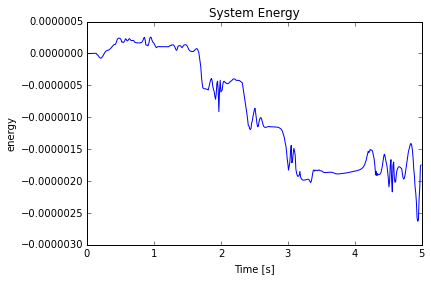

<function matplotlib.pyplot.show>

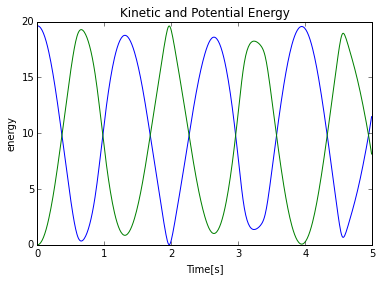

In [14]:
# The energy of the system is calculated and plotted
%matplotlib inline 
plt.plot(tspan,te-te[0])
plt.xlabel("Time [s]")
plt.ylabel("energy")
plt.title("System Energy")
plt.show()

plt.plot(tspan,pe,tspan,ke)
plt.xlabel("Time[s]")
plt.ylabel("energy")
plt.title("Kinetic and Potential Energy")
plt.show

In [15]:
%qtconsole